# Hidden Objects

In [7]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.filters import gaussian
from skimage.measure import label
from pathlib import Path
from skimage import exposure
from matplotlib.transforms import Affine2D
from skimage.filters import threshold_otsu
import pandas as pd
from collections import defaultdict
import seaborn as sns



## Identificable object

(128, 128) (21, 21)


C:\Users\oriol.alas\AppData\Local\Temp\ipykernel_32740\2905751858.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


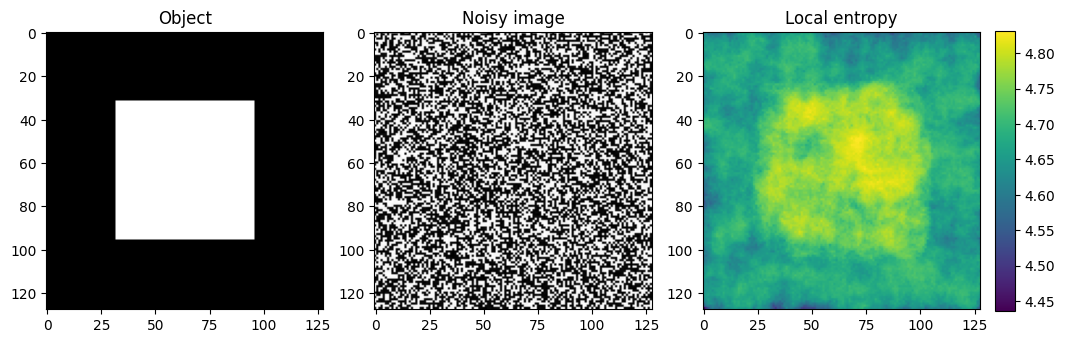

In [180]:
def get_noise(img):
    rng = np.random.default_rng(seed=42)

    noise = (img * rng.random(img.shape) - 0.5
            * img).astype(np.uint8)
    return noise


object_img = np.full((128, 128), 28, dtype=np.uint8)
object_img[32:-32, 32:-32] = 30

def get_entropy_img(object_img):


    noise = get_noise(object_img)
    img = noise + 128
    entr = disk(10)
    print(img.shape, entr.shape)
    entr_img = entropy(img, entr)
    return entr_img

noised = get_noise(object_img)
entr_img = get_entropy_img(object_img)

def plot_entropy(object_img, noised, entr_img):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
    img0 = ax0.imshow(object_img, cmap='gray')
    ax0.set_title("Object")
    ax1.imshow(noised, cmap='gray')
    ax1.set_title("Noisy image")
    img2= ax2.imshow(entr_img, cmap='viridis')
    ax2.set_title("Local entropy")
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
    fig.colorbar(img2, cax=cbar_ax)
    fig.tight_layout()

plot_entropy(object_img, noised, entr_img)

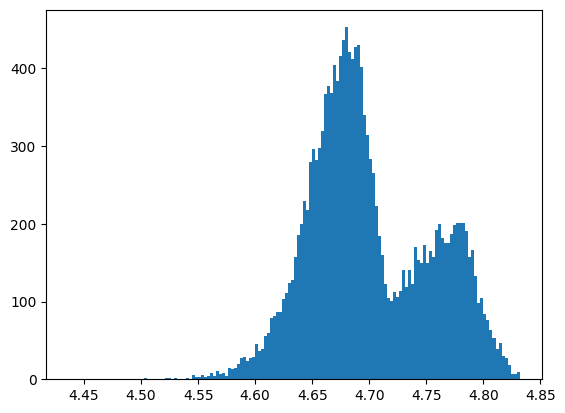

In [255]:
ax = plt.hist(entr_img.ravel(), bins=150)

C:\Users\oriol.alas\AppData\Local\Temp\ipykernel_23788\159714016.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


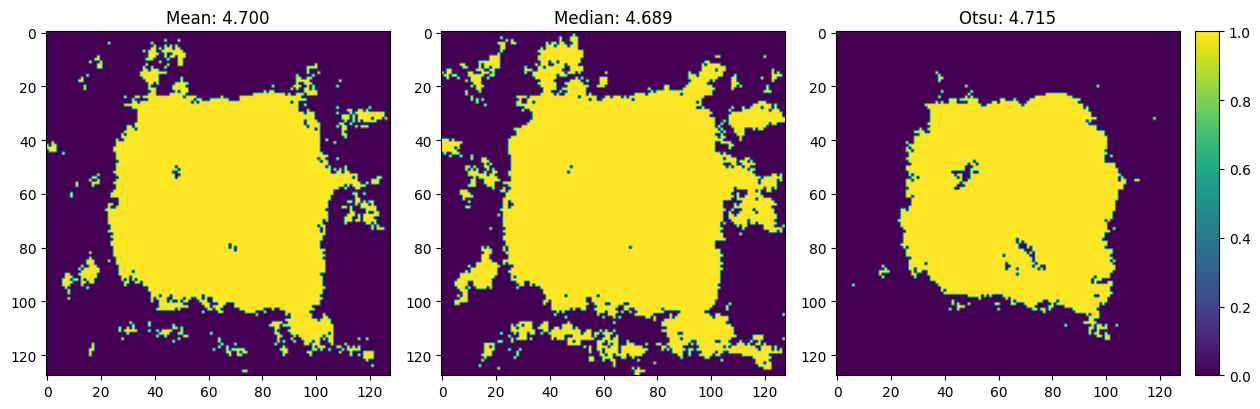

In [256]:


def plot_thresholding(entr_img):
    mean = entr_img.mean()
    median = np.percentile(entr_img, 50)
    otsu = threshold_otsu(entr_img)

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    img0 = ax0.imshow(entr_img > mean, cmap='viridis')
    ax0.set_title("Mean: {:.3f}".format(mean))
    ax1.imshow(entr_img > median, cmap='viridis')
    ax1.set_title("Median: {:.3f}".format(median))
    img2 = ax2.imshow(entr_img > otsu, cmap='viridis')
    ax2.set_title("Otsu: {:.3f}".format(otsu))
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([1, 0.07, 0.02, 0.86])
    fig.colorbar(img2, cax=cbar_ax)
    fig.tight_layout()

plot_thresholding(entr_img)

Text(0.5, 1.0, 'Connected components: 4')

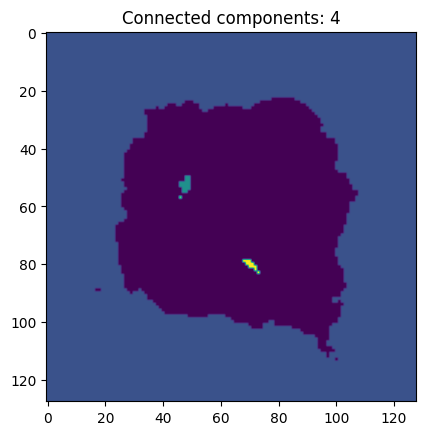

In [257]:
def connected_components(img, sigma=1.0, t=0.5, connectivity=2):
    blurred_image = gaussian(img, sigma=sigma)
    binary_mask = blurred_image < t
    labeled_img, count = label(binary_mask, connectivity=connectivity, return_num=True)
    return labeled_img, count

otsu = threshold_otsu(entr_img)
labeled_img, count = connected_components(entr_img > otsu)
plt.imshow(labeled_img)
plt.title("Connected components: {}".format(count))

In [347]:
def mse_component(otsu_hold):
    fig = plt.figure(figsize=(8, 8))
    gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
    ax = fig.add_subplot(gs[1, 0])
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
    ax.imshow(otsu_hold)
    ax_histx.fill_between(range(len(otsu_hold.sum(0))), otsu_hold.sum(0))
    mean_cols = otsu_hold.sum(0).mean()
    median_cols = np.percentile(otsu_hold.sum(0), 50)
    ax_histx.plot([0, len(otsu_hold.sum(0))-1], [mean_cols] * 2, 'orange', label='mean')
    ax_histx.plot([0, len(otsu_hold.sum(0))-1], [median_cols] * 2, 'y', label="median")
    ax_histx.legend(loc="best", bbox_to_anchor=(0.5, 0., 0.5, 0.5), fontsize="x-small")
    ax_histx.set_xticks([])
    ax_histy.fill_betweenx(range(len(otsu_hold.sum(1))), otsu_hold.sum(1))
    ax_histy.set_yticks([])
    mean_rows = otsu_hold.sum(1).mean()
    median_rows = np.percentile(otsu_hold.sum(1), 50)
    ax_histy.plot([otsu_hold.sum(1).mean()] * 2, [0, len(otsu_hold.sum(0)) - 1], 'orange', label="mean")
    ax_histy.plot([median_rows] * 2, [0, len(otsu_hold.sum(0)) - 1], 'y', label="median")
    ax_histy.legend(loc="best",  fontsize="x-small")
    fig.tight_layout()
    return {
        "cols": {
            "mean": ((mean_cols - otsu_hold.sum(0)) ** 2).mean(),
            "median": ((median_cols - otsu_hold.sum(0)) ** 2).mean(),
        },
        "rows": {
            "mean": ((mean_rows - otsu_hold.sum(1)) ** 2).mean(),
            "median": ((median_rows - otsu_hold.sum(1)) ** 2).mean(),
        }
    }
mse_component(entr_img > otsu)

NameError: name 'otsu' is not defined

## Non-Identificable Object

C:\Users\oriol.alas\AppData\Local\Temp\ipykernel_23788\3710168962.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


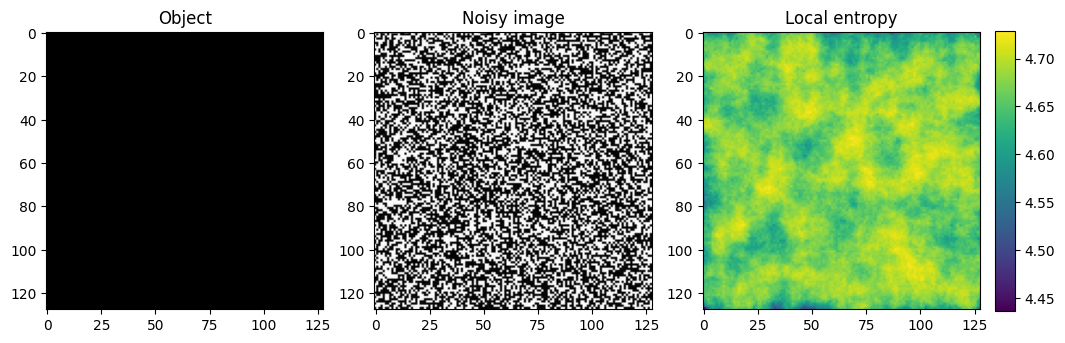

C:\Users\oriol.alas\AppData\Local\Temp\ipykernel_23788\159714016.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


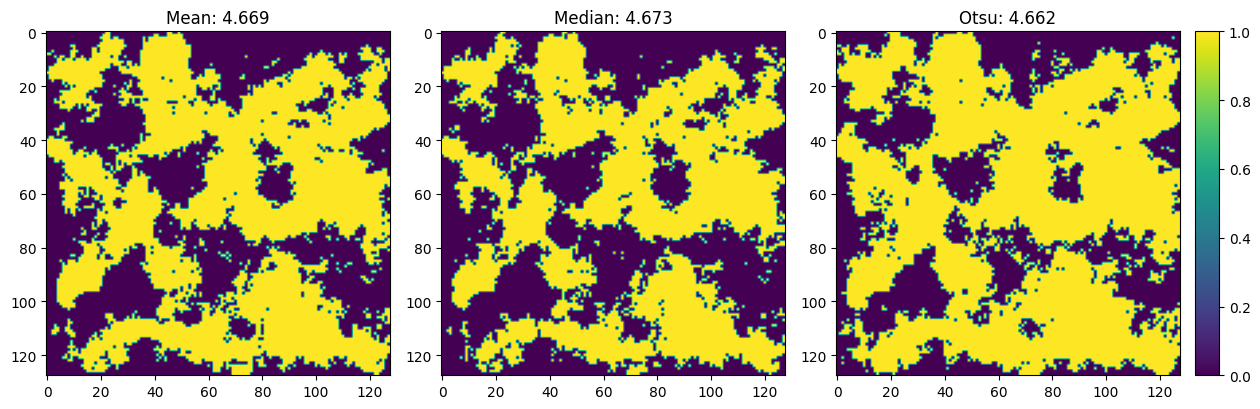

In [266]:
object_img = np.full((128, 128), 28, dtype=np.uint8)
noised = get_noise(object_img)
entr_img = get_entropy_img(object_img)
plot_entropy(object_img, noised, entr_img)
plt.show()
plot_thresholding(entr_img)

Text(0.5, 1.0, 'Connected components: 31')

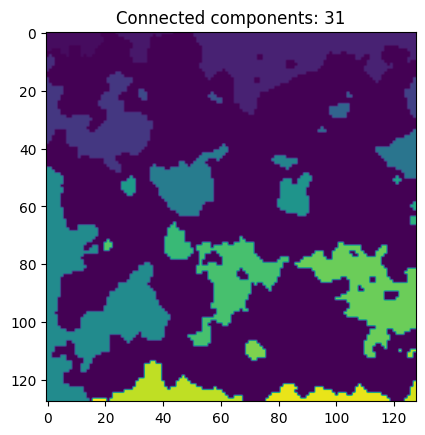

In [267]:
otsu = threshold_otsu(entr_img)
labeled_img, count = connected_components(entr_img > otsu)
plt.imshow(labeled_img)
plt.title("Connected components: {}".format(count))

C:\Users\oriol.alas\AppData\Local\Temp\ipykernel_23788\1667008666.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


{'cols': {'mean': 255.027099609375, 'median': 262.0},
 'rows': {'mean': 476.886474609375, 'median': 508.703125}}

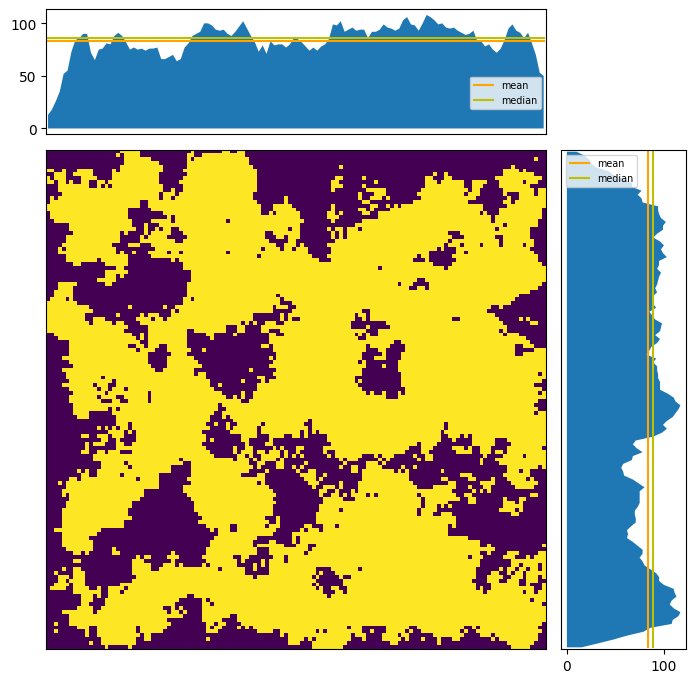

In [268]:
mse_component(entr_img > otsu)

## Satellite imagery

In [5]:
import rasterio as rio
from rasterio.plot import show
from rasterio.merge import merge
from pathlib import Path
from PIL import Image
import cv2
import matplotlib.pyplot as plt

..\..\imgs\s2_cloudy\ROIs1158_spring_s2_cloudy_101_p112.tif


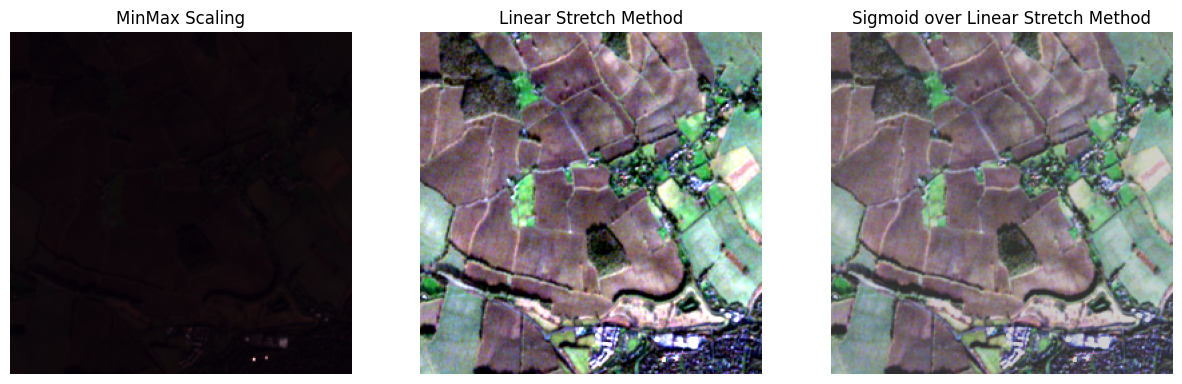

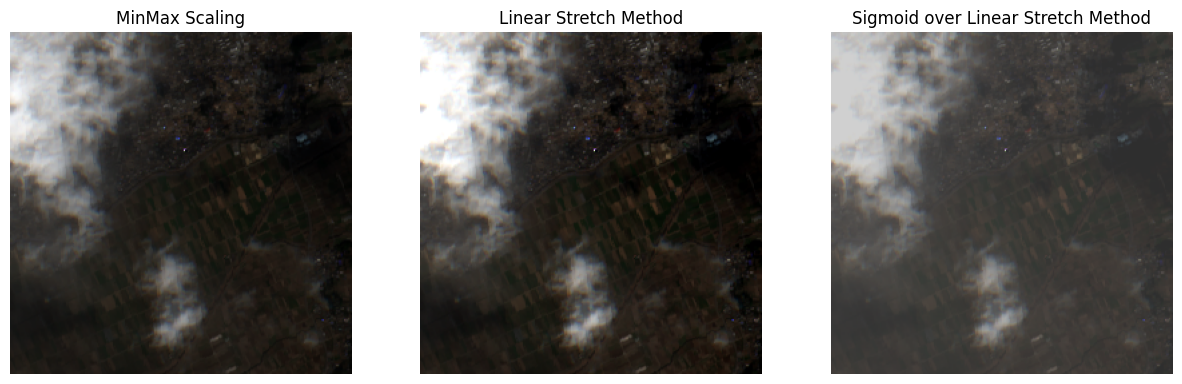

In [13]:
path = Path('../../imgs')
images = {p.name: p  for p in path.iterdir()}
path_img = images['s2_cloudy'].iterdir().__next__()
print(path_img)
cloudy = rio.open(path_img)
path_img = images['s2'].iterdir().__next__()
cloudless = rio.open(path_img)

def normalize(x):
    return (x - x.min()) / (x.max() - x.min()) * 255

def scaled(x):
    min_val, max_val = np.percentile(x, (2, 98))

    # Scale the pixel values to the range of 0-255
    return np.interp(x, (min_val, max_val), (0, 255)).astype(np.uint8)

def sigmoid(x):
    return 255 / (1 + np.exp(-3 * (scaled(x) / 255 - 0.5)))


def get_tci(img):
    r = sigmoid(img.read(4))
    g = sigmoid(img.read(3))
    b = sigmoid(img.read(2))
    rgb = np.stack([r, g, b])
    rgb = (rgb.transpose(1, 2, 0)).astype(np.uint8)
    return rgb

def get_array_img(r, g, b):
    rgb = np.stack([r,g,b])
    rgb = (rgb.transpose(1, 2, 0)).astype(np.uint8)
    return rgb

def show_corrections(img):
    r, g, b = img.read(4), img.read(3), img.read(2)
    fix, axs = plt.subplots(1, 3, figsize=(15, 9))
    for (name, correction_func), ax in zip([("MinMax Scaling", normalize), ("Linear Stretch Method", scaled), ("Sigmoid over Linear Stretch Method", sigmoid)], axs):
        _bands = list(map(lambda x: correction_func(x), [r, g, b]))
        array_img = get_array_img(*_bands)
        ax.imshow(array_img)
        ax.set_title(name)
        ax.axis('off')
    plt.show()

show_corrections(cloudless)
show_corrections(cloudy)

cloudy = get_tci(cloudy)
cloudless = get_tci(cloudless)


C:\Users\oriol.alas\AppData\Local\Temp\ipykernel_32740\1667008666.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


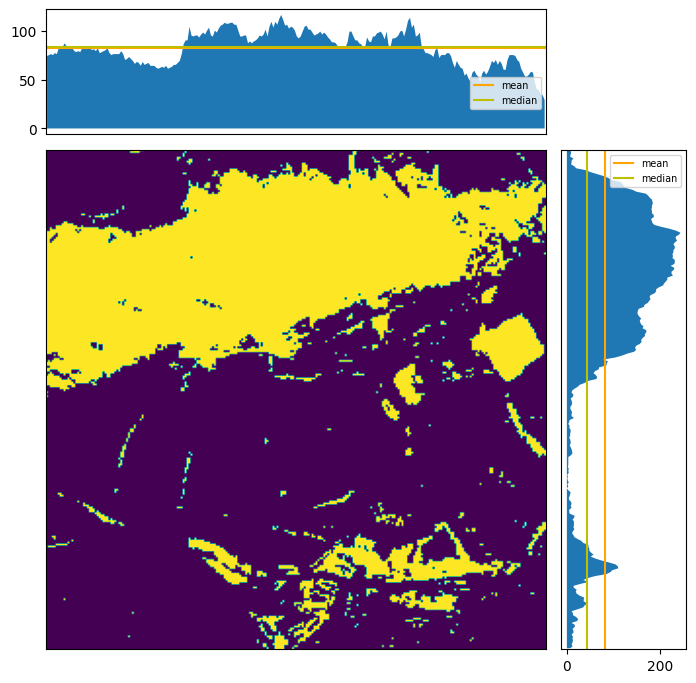

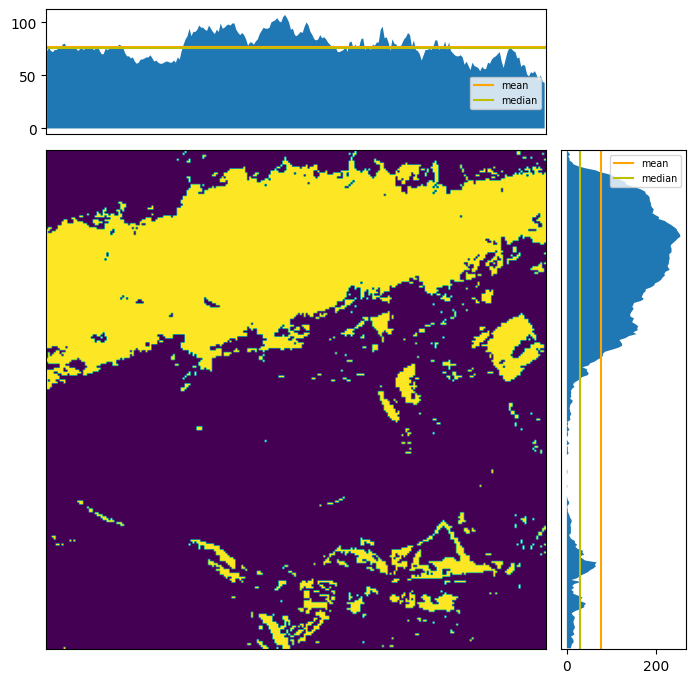

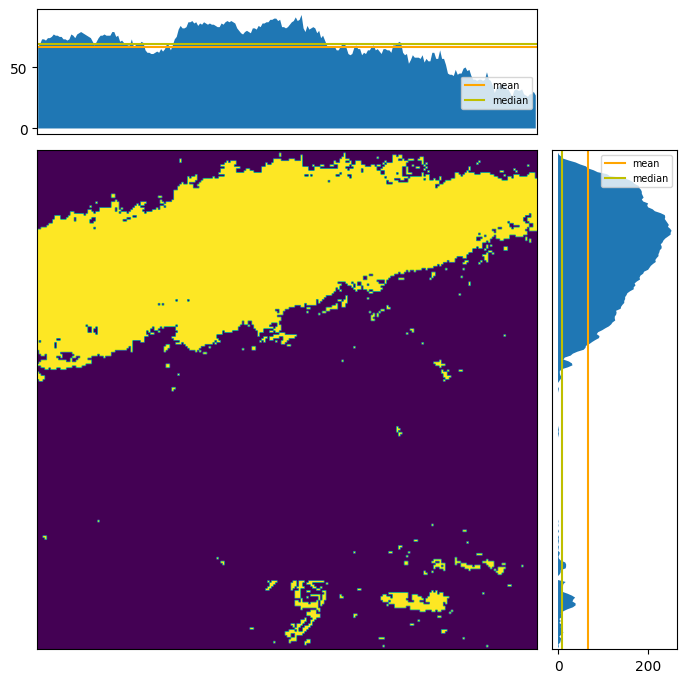

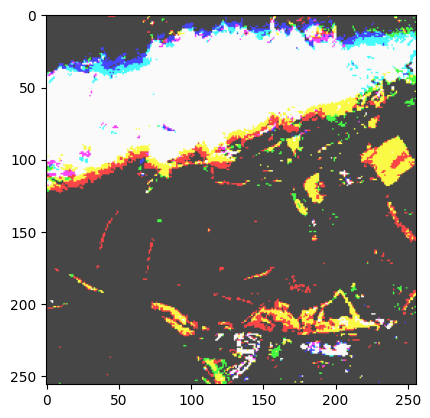

In [343]:
def get_umbralization(img):
    mses = []
    otsus = []
    for b in range(3):
        otsu = threshold_otsu(img[:, :, b])
        binarized = img[:, :, b] > otsu
        mses.append(mse_component(binarized))
        otsus.append(binarized)
    arr = np.array(otsus).transpose(1, 2, 0).astype(np.uint)
    plt.show()
    plt.imshow(arr * 180 + 70) 
    return mses
mses_cloudy = get_umbralization(cloudy)

C:\Users\oriol.alas\AppData\Local\Temp\ipykernel_32740\1667008666.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


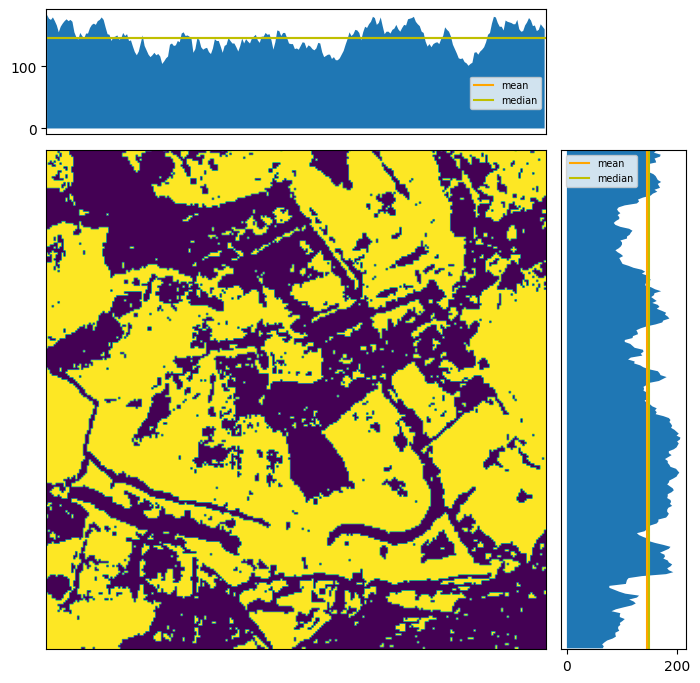

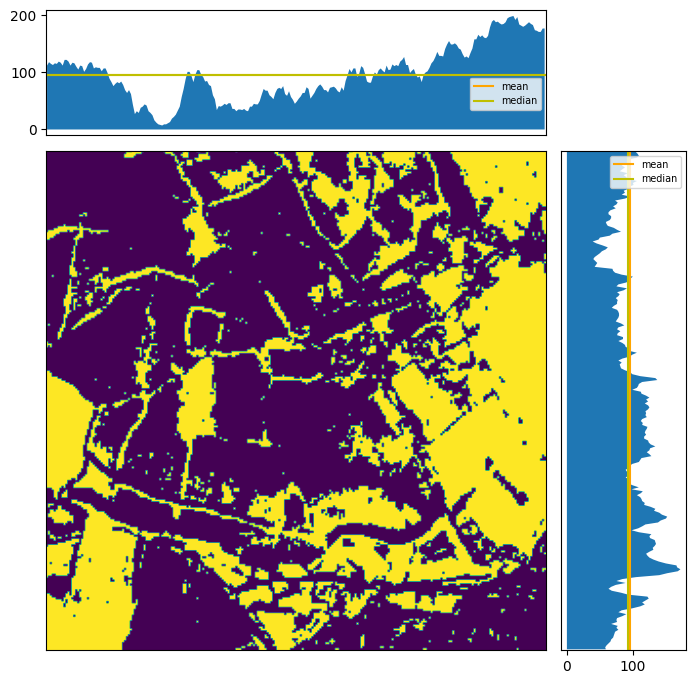

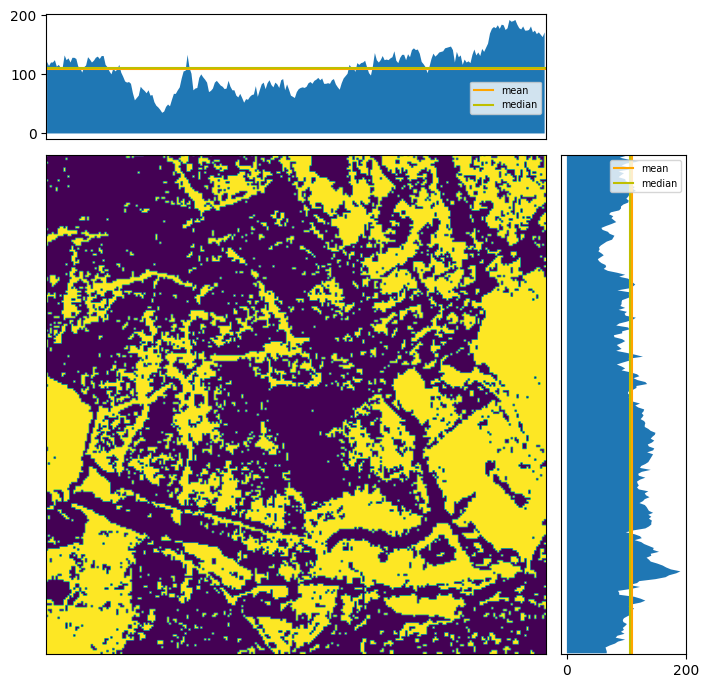

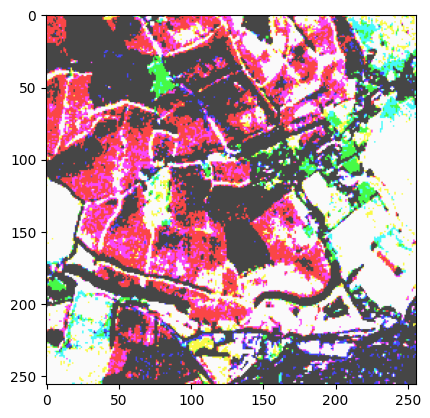

In [344]:
mses_cloudless = get_umbralization(cloudless)

In [345]:
dd = defaultdict(list)
for b, mses in zip(['r', 'g','b'], mses_cloudless):
    for axis, values in mses.items():
        dd['type'].append('cloudless')
        dd['color'].append(b)
        dd['axis'].append(axis)
        for metric_name, metric in values.items():
            dd[metric_name].append(metric)
for b, mses in zip(['r', 'g','b'], mses_cloudy):
    for axis, values in mses.items():
        dd['type'].append('cloudy')
        dd['color'].append(b)
        dd['axis'].append(axis)
        for metric_name, metric in values.items():
            dd[metric_name].append(metric)
df = pd.DataFrame(dd)
df

type color  axis         mean        median
0   cloudless     r  cols   382.872986    383.273438
1   cloudless     r  rows  1338.146423   1347.960938
2   cloudless     g  cols  2269.225082   2269.261719
3   cloudless     g  rows   714.686020    722.574219
4   cloudless     b  cols  1287.457993   1291.957031
5   cloudless     b  rows   713.762680    717.292969
6      cloudy     r  cols   289.792969    290.921875
7      cloudy     r  rows  6707.277344   8262.593750
8      cloudy     g  cols   166.769394    167.792969
9      cloudy     g  rows  7260.480331   9517.843750
10     cloudy     b  cols   283.741211    290.468750
11     cloudy     b  rows  7446.780273  10799.914062

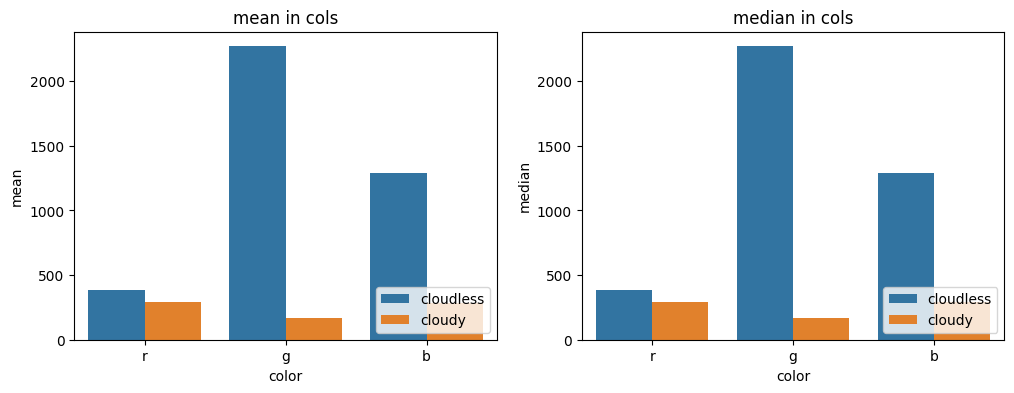

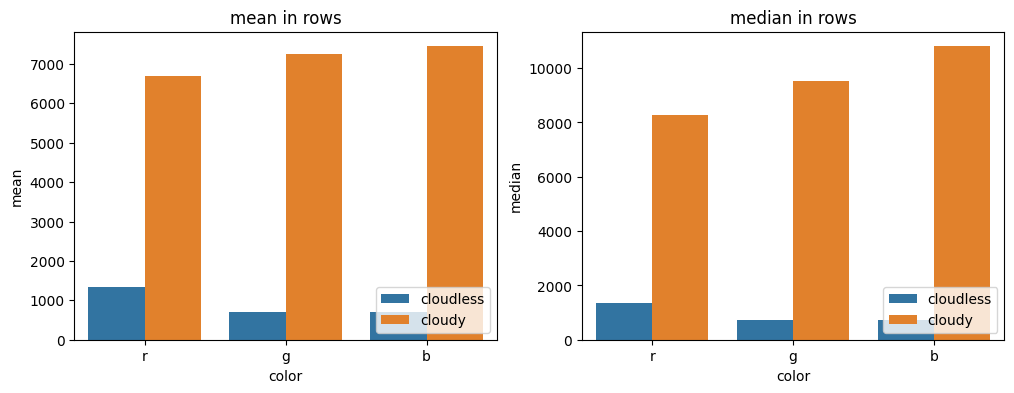

In [346]:
def show_barplot(df, axis):
    df = df[df.axis == axis]
    fig, axs = plt.subplots(1,2, figsize=(12, 4))
    for i, metric in enumerate(['mean', 'median']):
        sns.barplot(x='color', y=metric, hue='type', data=df, ax=axs[i])
        axs[i].set_title(metric + " in " +  axis)
        axs[i].legend(loc="lower right")
show_barplot(df, 'cols')
show_barplot(df, 'rows')